# Main run script

This script contains the main procedure to calculate global root zone storage capacities. 

This scripts only works in the conda environment **sr_env**. In this environment all required packages are available. If you have **not** installed and activated this environment before opening this script, you should check the installation section in the *README* file. 
 

### 1. Getting started
First, import all the required packages.

In [15]:
# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import math
from pathos.threading import ThreadPool as Pool
from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import random
from scipy.optimize import minimize

Here we import all the python functions defined in the scripts *f_catch_characteristics.py* and *f_preprocess_discharge.py*.

In [16]:
# import python functions
from f_catch_characteristics import *
from f_preprocess_discharge import *
from f_sr_calculation import *
from f_regression import *
from f_grid_to_catchments import *
from f_sr_reference_data import *

In [17]:
# # check which catchments are missing
# catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[:]
# el_id_list=[]
# for filepath in glob.iglob(f'{work_dir}/output/elevation/stats/*.csv'):
#     f = os.path.split(filepath)[1] # remove full path
#     f = f[:-4] # remove .year extension
#     el_id_list.append(f)
# dif = list(set(catch_list) - set(el_id_list))
# len(dif)

### 2. Define working and data directories
Here we define the working directory, where all the scripts and output are saved.

We also define the data directory where you have the following subdirectories:

/data/forcing/*netcdf forcing files*\
/data/shapes/*catchment shapefiles*\
/data/gsim_discharge/*gsim discharge timeseries*


In [18]:
# Check current working directory (helpful when filling in work_dir below)
os.getcwd()

'/home/fransjevanoors/global_sr_module'

In [19]:
# define your script working directory
# work_dir=Path("/mnt/u/LSM root zone/global_sr/")
# work_dir=Path('/tudelft.net/staff-umbrella/LSM root zone/global_sr')
work_dir=Path("/scratch/fransjevanoors/global_sr")

# define your data directory
data_dir=Path(f'{work_dir}/data')

Here we create the output directory inside your working directory. In the remainder of this module, the same command will be used regularly to create directories.

In [20]:
# make output directory
if not os.path.exists(f'{work_dir}/output'):
    os.makedirs(f'{work_dir}/output')
out_dir = Path(f"{work_dir}/output")

### 2. GSIM discharge data
### 2.1 Catchment id lists
The GSIM discharge data contains yearly discharge files for ~30000 catchments. These files are stored here *{data_dir}/GSIM_data/GSIM_indices/TIMESERIES/yearly/* and origin from https://essd.copernicus.org/articles/10/765/2018/ and
https://essd.copernicus.org/articles/10/787/2018/.
Here we create lists of the catchment ids for later use, both with upper and lower characters. Files are saved in *out_dir/gsim/*


In [66]:
# get list of all catchment ids available in the GSIM yearly discharge timeseries data
gsim_id_list_up = []
gsim_id_list_lo = []
for filepath in glob.iglob(f'{data_dir}/GSIM_data/GSIM_indices/TIMESERIES/yearly/*'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-5] # remove .year extension
    fl = f.lower()
    gsim_id_list_up.append(f)
    gsim_id_list_lo.append(fl)

In [67]:
if not os.path.exists(f'{work_dir}/output/gsim'):
    os.makedirs(f'{work_dir}/output/gsim')
np.savetxt(f'{out_dir}/gsim/gsim_catch_id_list_up.txt',gsim_id_list_up,fmt='%s')
np.savetxt(f'{out_dir}/gsim/gsim_catch_id_list_lo.txt',gsim_id_list_lo,fmt='%s')

### 2.2 Preprocess data 
The GSIM yearly discharge timeseries are stored in *.year* files. A detailed explanation of the column names is provided in Table 3 and 4 in https://essd.copernicus.org/articles/10/787/2018/. Here we preprocess these data into readable *.csv* files for each catchment.

The preprocessing function *preprocess_gsim_discharge* is defined in the file *f_preprocess_discharge.py*. With this function we generate for each catchment a file with the yearly discharge timeseries and a file with the specifications of the catchment.

In [6]:
# make output directories
if not os.path.exists(f'{out_dir}/gsim/timeseries'):
    os.makedirs(f'{out_dir}/gsim/timeseries')

if not os.path.exists(f'{out_dir}/gsim/timeseries_selected'):
    os.makedirs(f'{out_dir}/gsim/timeseries_selected')
    
if not os.path.exists(f'{out_dir}/gsim/characteristics'):
    os.makedirs(f'{out_dir}/gsim/characteristics')

Here we do a test run with only 5 catchments to reduce computational time. Run all catchments on Delftblue using slurm and the *run_gsim_preprocessing.py* script.

In [13]:
# load catchment ids
gsim_id_list_lo = np.loadtxt(f'{out_dir}/gsim/gsim_catch_id_list_lo.txt',dtype=str) 

# select randomly 5 catchments
# gsim_id_list_lo = random.choices(gsim_id_list_lo,k=5)
gsim_id_list_lo = gsim_id_list_lo[50:150]

# define folder with discharge timeseries data
fol_in = f'{data_dir}/GSIM_data/GSIM_indices/TIMESERIES/yearly/'

# define output folder
fol_out = f'{out_dir}/gsim/'

# make lists for parallel computation
catch_list = gsim_id_list_lo
fol_in_list = [fol_in] * len(catch_list)
fol_out_list = [fol_out] * len(catch_list)

# run function
run_function_parallel(catch_list,fol_in_list,fol_out_list)

### 2.3 select GSIM catchments
Here we select GSIM catchments that are used for further analysis. The selection criteria are as follows:
 - timeseries after 1980 contains at least 10 years of data
 - area quality high or medium

If a year has less than 250 days with data, the year is set to nan, and we remove nan years from the timeseries.
It is ok to have non-consecutive years in our timeseries.

The function *select_catchments* in *f_preprocess_discharge.py* selects catchments and stores the selected timeseries in a separate folder.
Here we do a test run with only 5 catchments to reduce computational time. Run all catchments on Delftblue using slurm and the *run_gsim_selection.py* script.

In [14]:
# load catchment ids
gsim_id_list_lo = np.loadtxt(f'{out_dir}/gsim/gsim_catch_id_list_lo.txt',dtype=str) 

# select randomly 5 catchments
# gsim_id_list_lo = random.choices(gsim_id_list_lo,k=5)
gsim_id_list_lo = gsim_id_list_lo[50:150]

# make lists for parallel computation
catch_list = gsim_id_list_lo
data_dir_list = [data_dir] * len(catch_list)
out_dir_list = [out_dir] * len(catch_list)

# run function
run_function2_parallel(data_dir_list,out_dir_list,catch_list)

Make here lists of the selected catchment ids, that are stored in the previous step in the *timeseries_selected* folder

In [15]:
gsim_id_list_up_sel = []
gsim_id_list_lo_sel = []
for filepath in glob.iglob(f'{out_dir}/gsim/timeseries_selected/*'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .csv extension
    fl = f.lower()
    gsim_id_list_up_sel.append(f)
    gsim_id_list_lo_sel.append(fl)
    
np.savetxt(f'{out_dir}/gsim/gsim_catch_id_list_up_sel.txt',gsim_id_list_up_sel,fmt='%s')
np.savetxt(f'{out_dir}/gsim/gsim_catch_id_list_lo_sel.txt',gsim_id_list_lo_sel,fmt='%s')

### 3. Organize data

**Add Australia CAMELS catchments**\
The CAMELS-AU data is added to GSIM to get a better representation of climate regions. The discharge data is stored in /data/CAMELS_AUS/ and is processed using *preprocess_q_aus.py*
Output is stored in /output/camels-aus/

Here we assume all catchments are ok for Australia. 
- Copy all files in /output/camels_aus/ to /output/gsim/timeseries_selected/ (do manually) folder to complete the GSIM dataset, and move one folder up in output/
- And we need to make a new list with selected catchments including australia - see below.
- Copy all shapefiles of the selected GSIM and CAMELS-AUS catchments into /output/selected_shapes/
- Copy all selected q_timeseries in /output/gsim/timeseries_selected to /output/q_timeseries_selected/

In [59]:
gsim_id_aus_list_up_sel = []
gsim_id_aus_list_lo_sel = []
for filepath in glob.iglob(f'{out_dir}/q_timeseries_selected/*'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .csv extension
    fl = f.lower()
    gsim_id_aus_list_up_sel.append(f)
    gsim_id_aus_list_lo_sel.append(f)
    
np.savetxt(f'{out_dir}/gsim_aus_catch_id_list_up_sel.txt',gsim_id_aus_list_up_sel,fmt='%s')
np.savetxt(f'{out_dir}/gsim_aus_catch_id_list_lo_sel.txt',gsim_id_aus_list_lo_sel,fmt='%s')

In [60]:
catch_list = np.loadtxt(f'{out_dir}/gsim_aus_catch_id_list_up_sel.txt',dtype=str)
print(catch_list)
print('The amount of selected catchments is:',len(catch_list))

['102101A' 'ar_0000001' 'ar_0000005' ... 'G9030124' 'G9030250' 'G9070142']
The amount of selected catchments is: 8658


### 5. From gridded data to catchment timeseries
For this step go to the notebook *run_script_grid_to_catchments*. This part is run in another notebook. The output data of this script can be found in:
- */output/p_gswp_timeseries_selected_catchments*
- */output/ep_gswp_timeseries_selected_catchments*
- */output/tas_gswp_timeseries_selected_catchments*

all daily output timeseries are collected together in */output/forcing_timeseries/raw/*

Below we postprocess the daily outputs in this folder using the *process_forcing_timeseries* that was defined in *f_grid_to_catchments.py*

In [9]:
# define input directory
fol_in=f'{work_dir}/output/forcing_timeseries/raw'
# define output directory
fol_out=f'{work_dir}/output/forcing_timeseries/processed'

# get catch_id_list
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_up_sel.txt',dtype='str')

# define variables
# var = ['Ep','P','T']
var = ['ep','p','tas']

# run process_forcing_timeseries (defined in f_grid_to_catchments.py) for all catchments in catch_id_list
for catch_id in catch_id_list[0:5]:
    print(catch_id)
    process_forcing_timeseries(catch_id,fol_in,fol_out,var)

102101A
ar_0000001
ar_0000005
ar_0000006
ar_0000008


In [68]:
# run in parallel
# make lists for parallel computation
catch_list = catch_id_list[0:5]
fol_in_list = [fol_in] * len(catch_list)
fol_out_list = [fol_out] * len(catch_list)
var_list = [var] * len(catch_list)
run_function_parallel(catch_list,fol_in_list,fol_out_list,var_list)

### 6. Google earth engine for catchment characteristics
For this step go to the notebook *run_script_earthengine*. This part is run in another notebook. The output data of this script can be found in *work_dir/output/earth_engine_timeseries*.\\

- Treecover output is stored in */output/treecover/gsim_shapes_treecover.csv*

In [11]:
a = pd.read_csv(f'{work_dir}/output/treecover/gsim_shapes_treecover.csv')# this includes ausdata!

In [12]:
a

,catch_id,max_tc,mean_tc,min_tc,std_tc,max_ntc,mean_ntc,min_ntc,std_ntc,mean_nonveg
0,es_0000991,15.243561,13.808580,12.493691,0.636526,57.197720,56.313709,55.520272,0.392144,29.877711
1,us_0003601,14.275355,9.511785,6.392207,1.721643,67.860510,65.816688,62.263939,1.119623,24.671527
2,at_0000053,50.507838,50.102189,49.626189,0.215605,34.260899,33.568141,33.006469,0.299617,16.329669
3,br_0000155,77.748960,58.329329,8.940161,15.100569,64.931697,32.660881,15.749590,10.190070,9.009789
4,br_0000270,57.168027,52.837786,49.642269,1.824748,30.296366,28.051420,25.201100,1.248870,19.110795
...,...,...,...,...,...,...,...,...,...,...
8653,ca_0000685,22.964986,21.533746,20.533114,0.622028,57.624616,56.890292,55.757891,0.479737,21.575962
8654,br_0001618,29.386886,27.847346,25.567657,0.968407,67.103698,65.545956,64.460628,0.671841,6.606699
8655,ca_0003506,52.700973,39.405013,12.713426,8.301865,67.163324,44.873497,29.063317,8.865259,15.721489
8656,ca_0000056,55.742350,54.968785,52.830302,0.693286,33.468020,31.661629,30.733066,0.598757,13.369586


### 7. Catchment descriptor variables
For the global root zone storage capacity estimation, we need to calculate catchment descriptor variables. These descriptors can be climatological variables (e.g. mean precipitation (p_mean); seasonality of precipitation (si_p); timelag between maximum P and Ep (phi)) or landscape variables (e.g. mean treecover (tc); mean elevation (h_mean)). A detailed list of all the descriptors considered is provided here xxxxx.\
To calculate the catchment descriptor variables we use the *catch_characteristics* function from the *f_catch_characteristics.py* file. In this function you specify the variables of interest, the catchment ID and your in- and output folders. Then, based on all the timeseries you have generated in the preceding codes it will return a table with the catchment descriptor variables for all your catchments (that is saved as csv in your *work_dir/catchment_characteristics/catchment_characteristics_"data_sources".csv*).
data_sources is defined as a string of the source for p, ep and T, for example *data_sources = 'gswp-p_gleam-ep_gswp-t'*.

In [6]:
# define in and output folder
var_lc=['tc','ntc','nonveg','area','ir_mean','el_mean','el_min','el_max','el_std','drd','slp_mean','slp_max','slp_min','slp_std','cla','snd','slt','tpi']
var_cl=['p_mean','ep_mean','q_mean','t_mean','ai','hai','tdiff_max','tdiff_mean','idu_mean','idu_max','hpd_mean','hpd_max','hpf','lpf','si_p','si_ep','phi','de','dp','dt','sp','st','se','sd','sti','ftf']
var_sn=['idu_mean_l','idu_max_l','hpd_mean_l','hpd_max_l','hpf_l','lpf_l','si_pl','phi_l','de_l','dp_l','dt_l','sp_l','st_l','se_l','sd_l','sti_l']

catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[0:5] # test for 3 catchments -> run on delftblue for all catchments with catch_characteristics.py

data_sources = 'gswp-p_gleam-ep_gswp-t'

# make lists for parallel computation
catch_list = catch_id_list.tolist()
var_lc_list = [var_lc] * len(catch_list)
var_cl_list = [var_cl] * len(catch_list)
var_sn_list = [var_sn] * len(catch_list)
work_dir_list = [work_dir] * len(catch_list)
data_sources_list = [data_sources] * len(catch_list)

# run catch_characteristics (defined in f_catch_characteristics.py) for the catchments in your catch_id_list parallel
run_function_parallel_catch_characteristics(var_lc_list,var_cl_list,var_sn_list,catch_list,work_dir_list,data_sources_list)
print('done')

done


In [7]:
# check which catchments are missing
catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')
id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/catchment_characteristics/gswp-p_gleam-ep_gswp-t/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .csv extension
    id_list.append(f)
dif = list(set(catch_list) - set(id_list))
len(dif)

127

In [21]:
#combine all files in one dataframe
data_sources = 'gswp-p_gleam-ep_gswp-t'
# list al shapefiles    
files = glob.glob(f"{work_dir}/output/catchment_characteristics/{data_sources}/*")
li=[] #empty list
for filename in files:
    df = pd.read_csv(filename, index_col=0) #read file as dataframe
    li.append(df) #append file to list
f = pd.concat(li, axis=0) #concatenate lists
f.to_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv')

In [22]:
f

,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,el_std,drd,slp_mean,slp_max,slp_min,slp_std,cla,snd,slt,tpi
de_0000778,4.045309,2.057641,0.842493,7.638991,1.965994,0.337366,24.641665,20.637500,2.86,16.13,...,291.563173,0.198029,10.619948,33.791851,0.403270,7.677587,7.574111,11.43850,15.163390,1.40614
br_0001850,4.186528,2.943133,1.030596,25.107997,1.422473,0.967762,6.181352,4.359281,7.14,72.03,...,85.991458,0.603869,2.404713,19.018690,0.036460,1.452261,21.465250,30.03281,11.571600,3.32628
ca_0003156,1.235331,1.331096,0.017540,3.742158,0.928056,1.003734,43.900205,36.056585,5.33,30.03,...,49.419324,0.369454,0.353077,4.675838,0.000000,0.412188,13.336140,18.63596,17.658500,3.64355
br_0001299,3.123837,2.907271,1.032392,24.338485,1.074491,1.257753,6.634216,5.093589,4.47,24.80,...,204.314582,0.426015,4.164966,21.969494,0.126978,2.651690,14.335770,22.00644,6.715627,2.06243
br_0001843,4.453621,2.944259,1.377108,24.223189,1.512646,0.877896,6.469796,4.538261,7.15,73.73,...,93.561888,0.509427,2.582996,10.657210,0.153662,1.180128,18.867120,24.71507,9.273455,2.71033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ca_0001384,3.196726,1.852481,2.053996,2.880652,1.725645,0.341004,40.004254,33.168757,2.74,11.63,...,132.744086,0.443695,3.745704,19.904703,0.002320,2.461829,5.288717,22.22545,15.004920,2.14825
us_0001647,3.412146,2.749842,2.050785,18.061075,1.240852,0.855017,24.183295,20.816630,4.07,18.73,...,15.421329,0.548254,0.838095,1.561405,0.154006,0.249567,12.236070,35.50068,15.771400,3.79075
gb_0000044,2.269773,1.157692,1.016338,9.472414,1.960603,0.677501,17.949959,13.999706,3.36,17.43,...,61.397730,0.323072,2.210624,7.841141,0.187004,1.120093,14.062060,22.81675,27.029190,3.33438
br_0000392,4.171185,3.215613,1.172224,25.953768,1.297166,1.004279,4.744549,3.214524,9.28,87.60,...,229.008046,0.580163,2.312693,26.799967,0.000000,2.562056,15.720090,32.02823,10.318910,3.27995


In [9]:
# combine catchment geometries in single shapefile
shapefiles = glob.glob(f"{work_dir}/output/selected_shapes/*shp")[:]
li=[] #empty list
for filename in shapefiles:
    df = gpd.read_file(filename, index_col=None, header=0) #read shapefile as geopandas dataframe
    li.append(df) #append shapefile to list
f = pd.concat(li, axis=0) #concatenate lists
f = f.rename(columns={'FILENAME':'catch_id'})
f.index = f['catch_id']
f = f.drop(columns={'catch_id','Id'})
f.to_file(f'{out_dir}/geo_catchments.shp') #store geopandas dataframe as .shp

In [11]:
# fix australia shapes
a=gpd.read_file(f'{out_dir}/geo_catchments.shp')
a[8436:].catch_id = a[8436:].catch_id
# a = a.drop(columns={'CatchID'})
a.to_file(f'{out_dir}/geo_catchments.shp') #store geopandas dataframe as .shp

/home/fransjevanoors/miniconda3/envs/sr_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [23]:
# add lat - lon to catchment characteristics
a=gpd.read_file(f'{work_dir}/output/geo_catchments.shp')
a.index=a['catch_id']
a = a.to_crs(4326)
a['centroid'] = a.centroid
lon = a.centroid.x
lat = a.centroid.y
# a.centroid.point_object.x
# a.point_object.x

c = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
c['lat'] = lat
c['lon'] = lon
c.to_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv')
c

/tmp/ipykernel_1185327/3438770681.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  a['centroid'] = a.centroid
/tmp/ipykernel_1185327/3438770681.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = a.centroid.x
/tmp/ipykernel_1185327/3438770681.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = a.centroid.y


,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,slp_mean,slp_max,slp_min,slp_std,cla,snd,slt,tpi,lat,lon
de_0000778,4.045309,2.057641,0.842493,7.638991,1.965994,0.337366,24.641665,20.637500,2.86,16.13,...,10.619948,33.791851,0.403270,7.677587,7.574111,11.43850,15.163390,1.40614,47.723927,11.933343
br_0001850,4.186528,2.943133,1.030596,25.107997,1.422473,0.967762,6.181352,4.359281,7.14,72.03,...,2.404713,19.018690,0.036460,1.452261,21.465250,30.03281,11.571600,3.32628,-16.616687,-49.718967
ca_0003156,1.235331,1.331096,0.017540,3.742158,0.928056,1.003734,43.900205,36.056585,5.33,30.03,...,0.353077,4.675838,0.000000,0.412188,13.336140,18.63596,17.658500,3.64355,49.506681,-103.275867
br_0001299,3.123837,2.907271,1.032392,24.338485,1.074491,1.257753,6.634216,5.093589,4.47,24.80,...,4.164966,21.969494,0.126978,2.651690,14.335770,22.00644,6.715627,2.06243,-17.108293,-39.967427
br_0001843,4.453621,2.944259,1.377108,24.223189,1.512646,0.877896,6.469796,4.538261,7.15,73.73,...,2.582996,10.657210,0.153662,1.180128,18.867120,24.71507,9.273455,2.71033,-16.539263,-49.184522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ca_0001384,3.196726,1.852481,2.053996,2.880652,1.725645,0.341004,40.004254,33.168757,2.74,11.63,...,3.745704,19.904703,0.002320,2.461829,5.288717,22.22545,15.004920,2.14825,47.253879,-72.245291
us_0001647,3.412146,2.749842,2.050785,18.061075,1.240852,0.855017,24.183295,20.816630,4.07,18.73,...,0.838095,1.561405,0.154006,0.249567,12.236070,35.50068,15.771400,3.79075,33.018864,-83.604070
gb_0000044,2.269773,1.157692,1.016338,9.472414,1.960603,0.677501,17.949959,13.999706,3.36,17.43,...,2.210624,7.841141,0.187004,1.120093,14.062060,22.81675,27.029190,3.33438,53.261171,-1.396872
br_0000392,4.171185,3.215613,1.172224,25.953768,1.297166,1.004279,4.744549,3.214524,9.28,87.60,...,2.312693,26.799967,0.000000,2.562056,15.720090,32.02823,10.318910,3.27995,-12.531370,-47.860721


ADD BEDROCK DEPTH, IWU IRRIGATION, OTHER GSIM VARIABLES

### 8. Select catchments based on area and water balance
- Area < 10000
- P > Q \
Save catchment characteristics dataframe of selected catchments as *catchment_characteristics_sel_area_wb.csv*, catch id list as *gsim_aus_catch_id_list_lo_sel_area_wb.txt*, and geo table *geo_catchments_sel_area_wb.shp* \
We select then 6422/8658 catchments

In [13]:
# catchment characteristics
c = pd.read_csv(f'{out_dir}/catchment_characteristics.csv',index_col=0)
c = c[c.area<10000]
c = c[c.p_mean>c.q_mean]
c.to_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv')

# catchment id list
catch_id = c.index.values
np.savetxt(f'{out_dir}/gsim_aus_catch_id_list_lo_sel_area_wb.txt',catch_id,fmt='%s')

# geopandas table
a=gpd.read_file(f'{out_dir}/geo_catchments.shp')
a.index = a.catch_id
a = a.loc[c.index]
a.to_file(f'{out_dir}/geo_catchments_sel_area_wb.shp') #store geopandas dataframe as .shp

### 8. Calculate root zone storage capacity
Here we calculate the catchment root zone storage capacity (Sr) based on catchment water balances. First, catchment root zone storage deficits (Sd) are computed as the cumulative difference between P and Et (transpiration). The result of one catchment is visualised in a figure. Second, the Sr is then calculated based on an extreme value analysis of the storage deficits for different return periods. A detailed description of this method can be found here xxxxxx.

Here we use the *run_sd_calculation* and *run_sr_calculation* functions from the *f_sr_calculation* file. The Sd result of one catchment is visualised using *plot_sd*. The Sr results are merged using the *merge_sr* function and visualised using the *plot_sr* function. The output of both storage deficit and Sr calculations are saved in your *work_dir/output/sr_calculation*.


In [25]:
# make output directories
if not os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments'):
    os.makedirs(f'{work_dir}/output/sr_calculation/sd_catchments')
    
if not os.path.exists(f'{work_dir}/output/sr_calculation/sr_catchments'):
    os.makedirs(f'{work_dir}/output/sr_calculation/sr_catchments')

Calculate storage deficits using the *run_sd_calculation* function from *f_sr_calculation* -> run parallel with *run_sr_calculation.py* on delftblue

In [7]:
# define directories
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
snow_ids = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')
snow_dir = f'{work_dir}/output/snow/timeseries'

c = np.loadtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype=str) 
catch_id_list = c[0:5]
pep_dir_list = [pep_dir] * len(catch_id_list)
q_dir_list = [q_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list)
snow_id_list = [snow_ids] * len(catch_id_list)
snow_dir_list = [snow_dir] * len(catch_id_list)

run_sd_calculation_parallel(catch_id_list,pep_dir_list,q_dir_list,out_dir_list,snow_id_list,snow_dir_list)

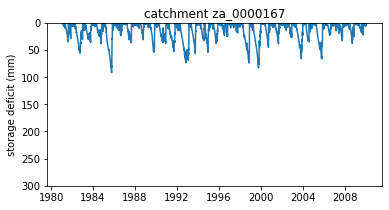

In [8]:
# plot sd example - use the first catchment from catch_id_list
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
plot_sd(catch_id_list[0], sd_dir)

We cannot calculate Sd for all catchments because sometimes Et>Pe and sometimes timeseries of Q and P-EP do not match.\
Here make lists of catchments for which Sd was calculated

In [11]:
sd_list = []
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/*'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .csv extension
    sd_list.append(f)
np.savetxt(f'{work_dir}/output/sr_calculation/sd_list.txt',sd_list,fmt='%s')
print(len(sd_list))

5597


Calculate Sr using the *run_sr_calculation* function from *f_sr_calculation* and merge the catchment Sr values into one dataframe with *merge_sr_catchments*. The functions return a table with the catchment Sr values for the different return periods.

In [12]:
# run max min root zone year
# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sr_catchments'

# define return periods
rp_array = [2,3,5,10,20,30,40,50,60,70,80]

c = np.loadtxt(f'{work_dir}/output/sr_calculation/sd_list.txt',dtype=str) 
catch_id_list = c[:]
sd_dir_list = [sd_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list) 
rp_array_list = [rp_array] * len(catch_id_list) 

run_sr_calculation_parallel(catch_id_list,rp_array_list,sd_dir_list,out_dir_list) #run all catchments parallel on delftblue

In [5]:
# run max min - change sr calculation function in f_sr_calculation!!!
# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sr_catchments/sr_maxmin'

# define return periods
rp_array = [2,3,5,10,20,30,40,50,60,70,80]

c = np.loadtxt(f'{work_dir}/output/sr_calculation/sd_list.txt',dtype=str) 
catch_id_list = c[1000:]
sd_dir_list = [sd_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list) 
rp_array_list = [rp_array] * len(catch_id_list) 

run_sr_calculation_parallel(catch_id_list,rp_array_list,sd_dir_list,out_dir_list) #run all catchments parallel on delftblue

In [13]:
# merge catchment sr dataframes into one dataframe - sr max min root zone year
sr_dir = f'{work_dir}/output/sr_calculation/sr_catchments'
out_dir = f'{work_dir}/output/sr_calculation/'
merge_sr_catchments(sr_dir,out_dir)

,2,3,5,10,20,30,40,50,60,70,80
catch_id,,,,,,,,,,,
za_0000167,42.244676,50.123918,58.899695,69.926766,80.504197,86.589133,90.879200,94.195597,96.899572,99.182445,101.157875
de_0000129,3.573606,4.317722,5.146506,6.187903,7.186836,7.761497,8.166651,8.479852,8.735215,8.950810,9.137369
es_0000787,97.760901,114.213299,132.537722,155.563004,177.649407,190.355170,199.313125,206.237990,211.884076,216.650870,220.775704
br_0001831,197.573212,210.361952,224.605851,242.503811,259.671963,269.548378,276.511555,281.894376,286.283178,289.988491,293.194798
es_0001076,110.477887,123.282567,137.544219,155.464486,172.654037,182.542761,189.514617,194.904147,199.298419,203.008351,206.218654
...,...,...,...,...,...,...,...,...,...,...,...
fr_0000086,141.360921,167.350715,196.297740,232.670694,267.560506,287.631753,301.782603,312.721787,321.640888,329.170975,335.686961
ca_0001025,37.108319,43.905170,51.475397,60.987653,70.112037,75.361070,79.061801,81.922617,84.255140,86.224408,87.928469
br_0001145,183.899455,232.076974,285.736338,353.161216,417.836777,455.043032,481.274592,501.552658,518.086076,532.044667,544.123410


In [8]:
# merge catchment sr dataframes into one dataframe - sr max min
sr_dir = f'{work_dir}/output/sr_calculation/sr_catchments/sr_maxmin'
out_dir = f'{work_dir}/output/sr_calculation/'
merge_sr_catchments_maxmin(sr_dir,out_dir)

,2,3,5,10,20,30,40,50,60
catch_id,,,,,,,,,
za_0000167,40.203450,48.712709,58.190187,70.098972,81.522165,88.093646,92.726743,96.308316,99.228498
de_0000129,3.258972,3.864702,4.539354,5.387079,6.200236,6.668025,6.997832,7.252785,7.460658
es_0000787,103.829790,122.279373,142.828228,168.648587,193.416095,207.664232,217.709608,225.475094,231.806567
br_0001831,204.057082,221.729405,241.412561,266.145139,289.869221,303.517100,313.139277,320.577612,326.642347
es_0001076,107.076231,121.924794,138.462890,159.243590,179.176935,190.644098,198.728801,204.978607,210.074293
...,...,...,...,...,...,...,...,...,...
fr_0000086,143.784203,169.723319,198.613898,234.915927,269.737705,289.769814,303.893070,314.810924,323.712633
ca_0001025,27.550393,32.337905,37.670160,44.370325,50.797285,54.494557,57.101248,59.116326,60.759290
br_0001145,171.559172,229.523135,294.082487,375.203582,453.016884,497.780957,529.341012,553.738222,573.630124


### 9. match reference data sr with catchment sr

In [10]:
# run stocker sr
catch_id_list = np.loadtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype=str)[:]
work_dir_list = [work_dir]*len(catch_id_list)
run_stocker_sr_parallel(catch_id_list,work_dir_list)

In [7]:
# run lan sr
catch_id_list = np.loadtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype=str)[:]
work_dir_list = [work_dir]*len(catch_id_list)
run_lan_sr_parallel(catch_id_list,work_dir_list)

In [8]:
# combine them in one dataframe
files = glob.glob(f"{work_dir}/output/sr_calculation/stocker/*")
li=[] #empty list
for filename in files:
    df = pd.read_csv(filename, index_col=0) #read file as dataframe
    li.append(df) #append file to list
f = pd.concat(li, axis=0) #concatenate lists

files = glob.glob(f"{work_dir}/output/sr_calculation/lan/*")
li=[] #empty list
for filename in files:
    df = pd.read_csv(filename, index_col=0) #read file as dataframe
    li.append(df) #append file to list
g = pd.concat(li, axis=0) #concatenate lists

df = pd.concat([f,g],axis=1)

In [10]:
df.to_csv(f'{work_dir}/output/sr_calculation/stocker_lan_sr_df.csv')

### 9. Regression

**move this to different script? to separate 'preprocessing' and 'analysis'?**

Here we run the linear regression model to predict the catchment Sr values based on the descriptor parameters. We use the *f_regression* function to calculate the linear regression parameters for the considered catchments.
We use the treecover data to separate the regression for high and low vegetation, the threshold values for tree cover (tc), non tree cover (ntc) and no-vegetation (nonveg) define this separation.

The output is a figure showing the estimated (step 8) and predicted (from regression) Sr values and a table with the regression parameter values, some statistics for the regression performance and the threshold values for tree cover. 

In [ ]:
# read the catchment characteristics and sr tables
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

# define the descriptor variables
dpar = ['p_mean','ep_mean','t_mean','si_p']

# return period of Sr estimate
rp = 20

# define the vegetation thresholds for the regression
tc_th, ntc_th, nonveg_th = 10, 0, 0

# run the regression (r_regression in f_regression.py)
run_regression(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)